In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from collections import Counter

2024-07-24 16:55:16.883506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read and Prepare data

In [2]:
df = pd.read_csv('data/processed/train_1_processed.csv', index_col=None)

#### Select language

In [3]:
display(Counter(df.language))

Counter({'en': 24108,
         'ja': 20431,
         'de': 18547,
         'na': 17855,
         'fr': 17802,
         'zh': 17229,
         'ru': 15022,
         'es': 14069})

In [4]:
df = df[df['language'] == 'fr']

#### Select only time series columns

In [5]:
# Regular expression to match date format "YYYY-MM-DD"
date_pattern = re.compile(r'\d{4}-\d{2}-\d{2}')

# Filter columns based on the regular expression
filtered_columns = [col for col in df.columns if date_pattern.match(col)]

# Create a new DataFrame with only the filtered columns
df = df[filtered_columns]

In [6]:
df.shape

(17802, 550)

#### Split training and test data

In [7]:
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

#### Missing Values Imputation

Missing values are imputed using forward linear interpolation. NAN values before a certain real value will be filled with 0 and the remaining NAN values will be filled using linear interpolation.

In [8]:
train_data = train_data.interpolate(method='linear', limit_direction='forward', axis=0)
test_data = test_data.interpolate(method='linear', limit_direction='forward', axis=0)

#### Normalize

In [9]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

#### Prepare data for LSTM

In [10]:
def create_multivariate_dataset(data, timesteps=7):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])  # Shape: (timesteps, num_pages)
        y.append(data[i + timesteps])    # Shape: (num_pages,)
    return np.array(X), np.array(y)

In [11]:
timesteps = 7
X_train, y_train = create_multivariate_dataset(scaled_train_data, timesteps=timesteps)
X_test, y_test = create_multivariate_dataset(scaled_test_data, timesteps=timesteps)

# Data Modeling

#### Define Multivariate LSTM

In [12]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(timesteps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dense(X_train.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

/Users/marcopellegrino/miniconda3/envs/marcoenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Train model

In [13]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 9.8116e-05 - val_loss: 3.2535e-07
Epoch 2/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 9.4706e-05 - val_loss: 9.9735e-07
Epoch 3/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.4463e-04 - val_loss: 3.2891e-07
Epoch 4/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 8.5218e-05 - val_loss: 2.9676e-07
Epoch 5/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 1.0687e-04 - val_loss: 3.3355e-07
Epoch 6/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 5.7807e-04 - val_loss: 4.2857e-07
Epoch 7/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.5325e-04 - val_loss: 3.7273e-07
Epoch 8/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.4257e-04 - val_loss: 9.9073e-07
Epoch 9/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 6.3231e-05 - val_loss: 1.0547e-06
Epoch 10/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 5.5678e-05 - val_loss: 3.2009e-07
Epoch 11/50
401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms

# Data Evaluation

In [14]:
y_pred = model.predict(X_test)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [15]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 6.242729922941872e-06


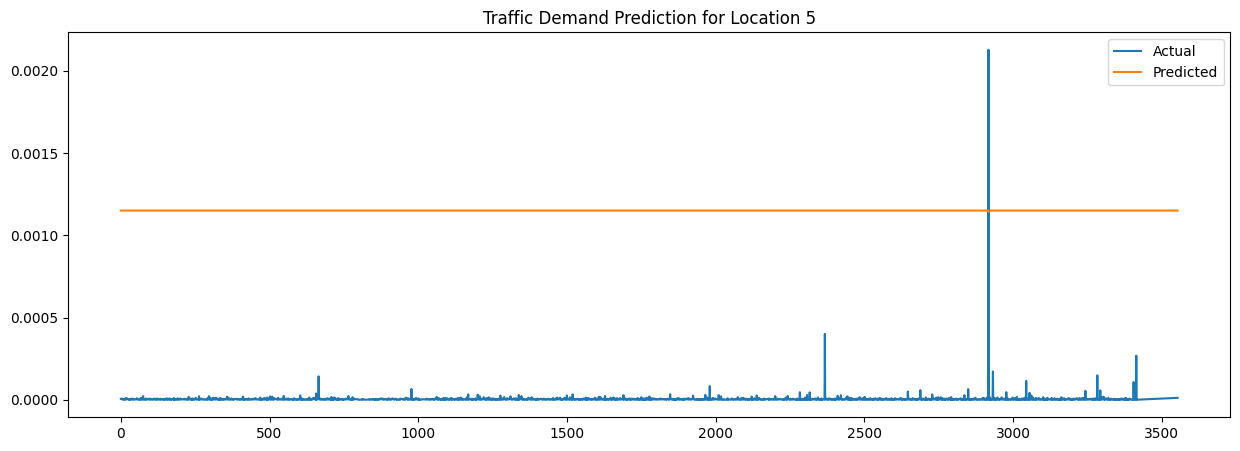

In [16]:
# Example: Plot predictions for a specific location (e.g., first location)
location_idx = 5

plt.figure(figsize=(15, 5))
plt.plot(y_test[:, location_idx], label='Actual')
plt.plot(y_pred[:, location_idx], label='Predicted')
plt.title(f'Traffic Demand Prediction for Location {location_idx}')
plt.legend()
plt.show()